# Introduction

The objective of this project is to apply machine learning on a Kaggle dataset called Titanic : https://www.kaggle.com/c/titanic

This dataset is split into 2 csv files: 

    1. train.csv
    2. test.csv

The idea is to predict who died on test.csv file based on train.csv file.

In [1]:
# Import libraries for data exploration
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# Import data

In [2]:
# Create datasets with our 2 csv files
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
dfs = [test,train]

for df in dfs:
    print(df.shape)

(418, 11)
(891, 12)


# Data Exploration

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Creating features

In [5]:
for df in dfs:
    df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

train.Title.unique()

array([&#39;Mr&#39;, &#39;Mrs&#39;, &#39;Miss&#39;, &#39;Master&#39;, &#39;Don&#39;, &#39;Rev&#39;, &#39;Dr&#39;, &#39;Mme&#39;, &#39;Ms&#39;,
       &#39;Major&#39;, &#39;Lady&#39;, &#39;Sir&#39;, &#39;Mlle&#39;, &#39;Col&#39;, &#39;Capt&#39;, &#39;Countess&#39;,
       &#39;Jonkheer&#39;], dtype=object)

In [6]:
for df in dfs:
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    
train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [7]:
for df in dfs:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [8]:
for df in dfs:
    df['IsAlone'] = 0
    df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1

train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


# Missing Data

In [9]:
train.info()
test.info()

&lt;class &#39;pandas.core.frame.DataFrame&#39;&gt;
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  Title        891 non-null    object 
 13  FamilySize   891 non-null    int64  
 14  IsAlone      891 non-null    int64  
dtypes: float64(2), int64(7), object(6)
memory usage: 104.5+ KB
&lt;class &#39;pandas.core.frame.DataFrame&#39;&gt;
RangeIndex: 418 entries, 0 to 417
Data columns (tot

In [10]:
# Dealing with Missing Data
for df in dfs:
    df['Age'].fillna(df['Age'].median(), inplace = True)
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace = True)
    df['Fare'].fillna(df['Fare'].median(), inplace = True)
    df.drop(columns = ['Cabin','FamilySize','SibSp','Parch','Ticket','Name'],inplace = True)

train.dropna(inplace = True)
test.fillna(0,inplace = True)

len(train)

891

We notice that we have missing data for the following columns:

    Age
    Cabin
    Embarked

In [11]:
# Some values could be wrong as well, let's check some columns
for i in train.columns:
    if i in ['Survived','Pclass','Sex','SibSp','Parch','Embarked']:
        print(train[i].unique())

[0 1]
[3 1 2]
[&#39;male&#39; &#39;female&#39;]
[&#39;S&#39; &#39;C&#39; &#39;Q&#39;]


# Format Data: X and y

In [12]:
X = train.drop(columns = ["Survived","PassengerId"])
X.head()

,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,3,male,22.0,7.2500,S,Mr,0
1,1,female,38.0,71.2833,C,Mrs,0
2,3,female,26.0,7.9250,S,Miss,1
3,1,female,35.0,53.1000,S,Mrs,0
4,3,male,35.0,8.0500,S,Mr,1


In [13]:
Y = train["Survived"]
Y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

# Format the Data: Scaling

In [14]:
X.dtypes

Pclass        int64
Sex          object
Age         float64
Fare        float64
Embarked     object
Title        object
IsAlone       int64
dtype: object

In [15]:
for i in X.columns:
    if i in ['Pclass','Sex','SibSp','Parch','Embarked']:
        print(X[i].unique())

[3 1 2]
[&#39;male&#39; &#39;female&#39;]
[&#39;S&#39; &#39;C&#39; &#39;Q&#39;]


In [16]:
X =     pd.get_dummies(X,   columns=['Sex','Embarked','Title'])
test =  pd.get_dummies(test,columns=['Sex','Embarked','Title'])
X.head()

,Pclass,Age,Fare,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,3,22.0,7.2500,0,0,1,0,0,1,0,0,1,0,0
1,1,38.0,71.2833,0,1,0,1,0,0,0,0,0,1,0
2,3,26.0,7.9250,1,1,0,0,0,1,0,1,0,0,0
3,1,35.0,53.1000,0,1,0,0,0,1,0,0,0,1,0
4,3,35.0,8.0500,1,0,1,0,0,1,0,0,1,0,0


In [17]:
test.head()

,PassengerId,Pclass,Age,Fare,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,892,3,34.5,7.8292,1,0,1,0,1,0,0,0,1,0,0
1,893,3,47.0,7.0000,0,1,0,0,0,1,0,0,0,1,0
2,894,2,62.0,9.6875,1,0,1,0,1,0,0,0,1,0,0
3,895,3,27.0,8.6625,1,0,1,0,0,1,0,0,1,0,0
4,896,3,22.0,12.2875,0,1,0,0,0,1,0,0,0,1,0


# Build a Classification Tree

In [18]:
X.describe()

,Pclass,Age,Fare,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,29.361582,32.204208,0.602694,0.352413,0.647587,0.188552,0.086420,0.725028,0.044893,0.207632,0.580247,0.141414,0.025814
std,0.836071,13.019697,49.693429,0.489615,0.477990,0.477990,0.391372,0.281141,0.446751,0.207186,0.405840,0.493796,0.348644,0.158668
min,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,22.000000,7.910400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,28.000000,14.454200,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,3.000000,35.000000,31.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,3.000000,80.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y)
random_state_number = 3
clf_dt = DecisionTreeClassifier(random_state=random_state_number)
clf_dt = clf_dt.fit(X_train,Y_train)

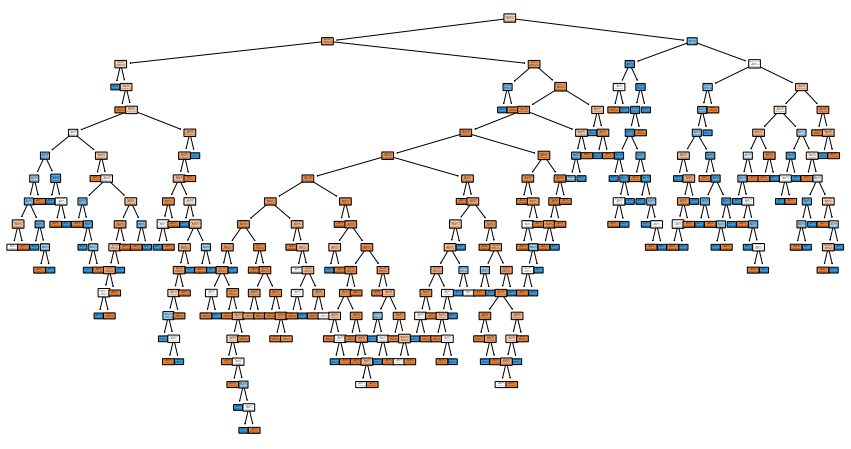

In [20]:
plt.figure(figsize=(15,8))
plot_tree(  clf_dt,
            filled = True,
            rounded = True,
            class_names = ["Didn't Survive", "Survived"],
            feature_names=X.columns)
plt.show()

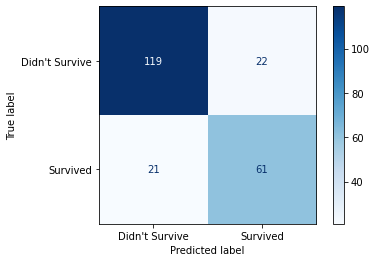

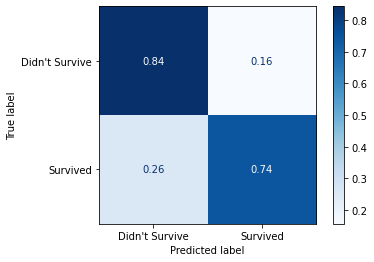

In [21]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    plot_confusion_matrix(  clf_dt,X_test,Y_test,
                            display_labels=["Didn't Survive","Survived"],
                            normalize=normalize,
                            cmap=plt.cm.Blues,)

# Cost Complexity Pruning: Visualize Alpha

In [22]:
path = clf_dt.cost_complexity_pruning_path(X_train,Y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]

clf_dts = []

for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=random_state_number,ccp_alpha=ccp_alpha)
    clf_dt.fit(X_train,Y_train)
    clf_dts.append(clf_dt)

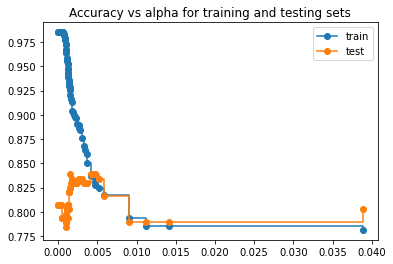

In [23]:
train_scores = [clf_dt.score(X_train,Y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test,Y_test) for clf_dt in clf_dts]

fig, ax = plt.subplots()
ax.set_xlabel = ("alpha")
ax.set_ylabel = ("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas,train_scores,marker='o',label="train",drawstyle="steps-post")
ax.plot(ccp_alphas,test_scores,marker='o',label="test",drawstyle="steps-post")
ax.legend()
plt.show()

# Cost Complexity Pruning: Cross Validation For Finding the Best Alpha

&lt;AxesSubplot:xlabel=&#39;tree&#39;&gt;

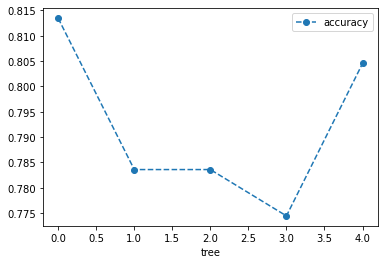

In [24]:
clf_dt = DecisionTreeClassifier(random_state=random_state_number,ccp_alpha=0.012)

scores = cross_val_score(clf_dt,X_train,Y_train,cv=5)
df = pd.DataFrame(data={'tree': range(5), 'accuracy': scores})

df.plot(x='tree',y='accuracy', marker='o', linestyle='--')

&lt;AxesSubplot:xlabel=&#39;alpha&#39;&gt;

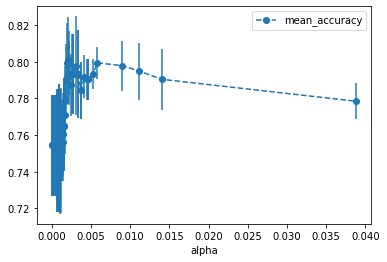

In [25]:
alpha_loop_values=[]

for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=random_state_number,ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt,X_train,Y_train,cv=5)
    alpha_loop_values.append([ccp_alpha,np.mean(scores),np.std(scores)])

alpha_results = pd.DataFrame(   alpha_loop_values,
                                columns = ['alpha','mean_accuracy','std'])

alpha_results.plot( x='alpha',
                    y='mean_accuracy',
                    yerr='std',
                    marker='o',
                    linestyle='--')

In [26]:
alpha_results[  (alpha_results['alpha']>0.002) & 
                (alpha_results['alpha']<0.025)].sort_values(by='mean_accuracy', ascending=False)

,alpha,mean_accuracy,std
47,0.002021,0.800887,0.023527
64,0.005819,0.799405,0.008623
48,0.002201,0.799394,0.017384
65,0.009011,0.797890,0.013620
54,0.003044,0.797868,0.026979
66,0.011162,0.794905,0.015483
63,0.005240,0.793390,0.008198
51,0.002605,0.793390,0.021638
52,0.002661,0.793390,0.021638
53,0.002764,0.793390,0.021638


In [27]:
ideal_ccp_alpha = 0.003280

# Building ideal classification tree

In [28]:
clf_dt_final = DecisionTreeClassifier(ccp_alpha=ideal_ccp_alpha,random_state=random_state_number)
clf_dt_final = clf_dt_final.fit(X_train,Y_train)

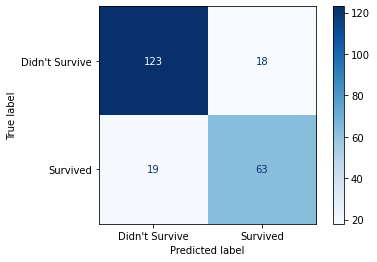

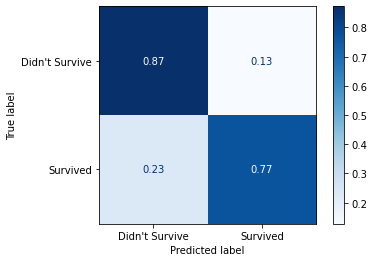

In [29]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    plot_confusion_matrix(  clf_dt_final,X_test,Y_test,
                            display_labels=["Didn't Survive","Survived"],
                            normalize=normalize,
                            cmap=plt.cm.Blues,)

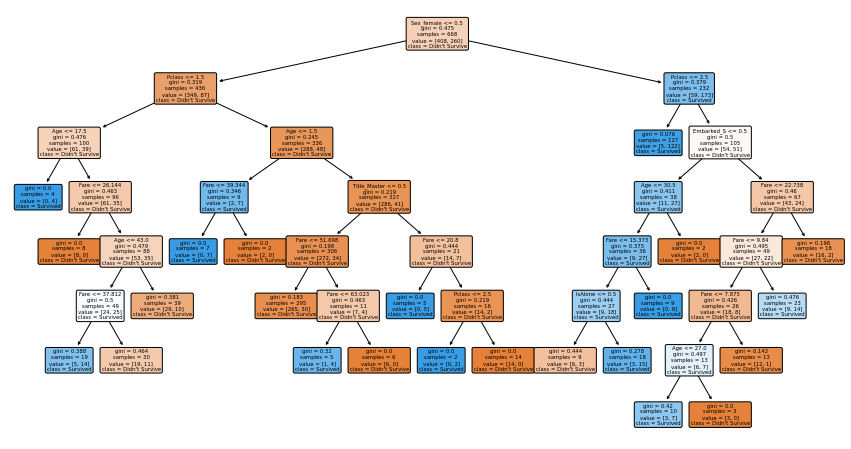

In [30]:
plt.figure(figsize=(15,8))
plot_tree(  clf_dt_final,
            filled = True,
            rounded = True,
            class_names = ["Didn't Survive", "Survived"],
            feature_names=X.columns)
plt.show()

# Submit Predictions

In [31]:
test.head()

,PassengerId,Pclass,Age,Fare,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,892,3,34.5,7.8292,1,0,1,0,1,0,0,0,1,0,0
1,893,3,47.0,7.0000,0,1,0,0,0,1,0,0,0,1,0
2,894,2,62.0,9.6875,1,0,1,0,1,0,0,0,1,0,0
3,895,3,27.0,8.6625,1,0,1,0,0,1,0,0,1,0,0
4,896,3,22.0,12.2875,0,1,0,0,0,1,0,0,0,1,0


In [32]:
X_test  = test.drop("PassengerId", axis=1).copy()
Y_pred = clf_dt_final.predict(X_test)

In [33]:
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('submission.csv', index=False)

In [34]:
submission = pd.read_csv('submission.csv')
submission.Survived.mean() # 0.383838 in train

0.3588516746411483

In [35]:
from checkAccuracy import accuracy

0.7666666666666667
